# Summary

In this notebook a deep concolutional neural network will be trained on images from a car driving in a simulation in order to output a steering angle for a self driving car.

The goals / steps of this project are the following:

* Use a driving simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

Training data was captured while driving manually in the simulation. To let the model drive the car back to the center of the lane once the car swerves to the border, three forward facing cameras are mounted on the car. One in the center of the windscreen and on to the left and to the right. The model learns the steering angle for the center camera. For the left and right camera images a constant value is added to steering angle to make the car drive back to the center. The training dataset contains about 10 000 images. But only every third image was used, as the images got recorded at 60 fps and therefore are very similar. For image augmentation I only flipped the images and steering angles accordingly.

The [NVidia Model for self driving cars](https://arxiv.org/pdf/1604.07316v1.pdf) architecture was used with added dropoutlayers to prevent overfitting, and a cropping and image normalization layer added as input layers.

With this model, the car is able to drive the first track very smoothly in both directions.

Things that I did not do but wanted to do if I had more time:

- I did not use any transferlearning to improve a good model. I always trained from scratch.
- I did not try to make the car drive on the second track.
- I did not add any image brightness augmentation.
- I did not use a better suited colorspace for the images.
- I did not use generators to load the images while training.
- I did not resize the images to make training faster.

# Data Generation

Udacity provides a Unity3D based simulator, where you can drive a car around a race track and record images from three different cameras mounted to the car. One in the center of the windscreen, one in the left and one in the right.

I drove two times around the track in the clockwise direction and two times in the counter clockwise direction and tried to stay in the middle of the track. I used the mouse to steer to generate better steering angles. Then I tried to capture some special situations, mostly when the car is at the very side of the track and is steered towards the center. After training the first good model the car had problems in the corners, where it could see water in front of it. So I captured extra images avoiding these situations. With that data the current model Version 1.1 was generated. When the model drives the car in the backward direction, there is one corner where the car gets very close to the edge and then stays there for a few seconds. I captured images to prevent this situation, but these some how mess up my model. When I train the model with theese images, the car is not able to even drive around the first corner.

# Loading the Data

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import os
import urllib.request
from urllib.request import urlretrieve
import zipfile
from scipy.misc import imresize

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 9)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17679408077692775830
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 7574952346
locality {
  bus_id: 1
}
incarnation: 10488031140304698151
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0"
]


## Download the data if not yet existing

In [4]:
def download_file(filename, source):
    if not os.path.exists("./" + filename):
        print("Images not yet downloaded, downloading...")
        urlretrieve(source, filename)
        print("extracting...")
        zip_ref = zipfile.ZipFile(filename, 'r')
        zip_ref.extractall(".")
        zip_ref.close()    
        print("done!")
    else:
        print("Images already downloaded.")

In [5]:
download_file("train_images.zip", "https://s3-eu-west-1.amazonaws.com/fabian.hertwig.carnddata/train_images.zip")

Images already downloaded.


In [6]:
log = pd.read_csv("./train_images/driving_log.csv", names = ["center", "left", "right", "steering", "acceleration", "break", "speed"])

In [7]:
log.head()

,center,left,right,steering,acceleration,break,speed
0,/Users/Fabian_privat/Documents/Projects/SelfDr...,/Users/Fabian_privat/Documents/Projects/SelfDr...,/Users/Fabian_privat/Documents/Projects/SelfDr...,-0.099724,0.000000,0,24.45676
1,/Users/Fabian_privat/Documents/Projects/SelfDr...,/Users/Fabian_privat/Documents/Projects/SelfDr...,/Users/Fabian_privat/Documents/Projects/SelfDr...,-0.099724,0.000000,0,24.25946
2,/Users/Fabian_privat/Documents/Projects/SelfDr...,/Users/Fabian_privat/Documents/Projects/SelfDr...,/Users/Fabian_privat/Documents/Projects/SelfDr...,-0.099724,0.081195,0,24.09601
3,/Users/Fabian_privat/Documents/Projects/SelfDr...,/Users/Fabian_privat/Documents/Projects/SelfDr...,/Users/Fabian_privat/Documents/Projects/SelfDr...,-0.095450,0.307716,0,24.07516
4,/Users/Fabian_privat/Documents/Projects/SelfDr...,/Users/Fabian_privat/Documents/Projects/SelfDr...,/Users/Fabian_privat/Documents/Projects/SelfDr...,-0.086903,0.538188,0,24.28159


In [8]:
log.describe()

,steering,acceleration,break,speed
count,9389.000000,9389.000000,9389.0,9389.000000
mean,-0.011582,0.686290,0.0,25.117452
std,0.214446,0.449681,0.0,7.767663
min,-1.000000,0.000000,0.0,3.885302
25%,-0.068635,0.000000,0.0,19.197160
50%,0.000574,1.000000,0.0,30.189980
75%,0.057904,1.000000,0.0,30.190290
max,1.000000,1.000000,0.0,30.686130


The original images are sampled at 60fps, but I do not want to use too similar images. So I will only read every third image and therefore reduce the samplerate to 20 fps.

In [9]:


def load_images(df, source_folder, camera, steering_add_mean, steering_add_std, image_step = 1, add_fliped_image = False):
    
    images = []
    steering_angles = []

    for i in range(0, len(df), image_step):
        name = df.loc[i, camera].split("/")[-1]
        path = source_folder + name

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        steering_angle = log.loc[i, "steering"]
        steering_angle += np.random.normal(steering_add_mean, steering_add_std)

        images.append(image)
        steering_angles.append(steering_angle)
        
        if add_fliped_image:
            image_flipped = np.fliplr(image)
            steering_angle_flipped = -steering_angle
            images.append(image_flipped)
            steering_angles.append(steering_angle_flipped)
    images = np.array(images)
    steering_angles = np.array(steering_angles)
    return images, steering_angles
    

In [10]:
center_images, center_steering_angles = load_images(
    log, "./train_images/IMG/", "center", 0, 0.0, image_step=3, add_fliped_image=True)

In [11]:
left_images, left_steering_angles = load_images(
    log, "./train_images/IMG/", "left", 0.1, 0.0, image_step=3, add_fliped_image=True)

In [12]:
right_images, right_steering_angles = load_images(
    log, "./train_images/IMG/", "right", -0.1, 0.0, image_step=3, add_fliped_image=True)

Here you can see the images from the three different cameras mounted on the cars front.

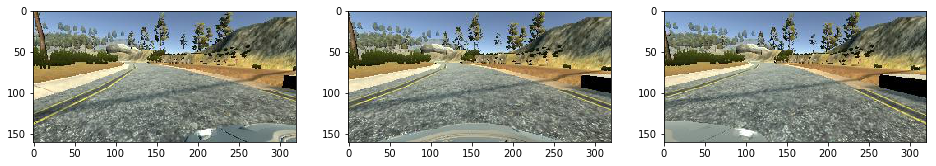

In [13]:
plt.subplot(131)

plt.imshow(left_images[0])
plt.subplot(132)

plt.imshow(center_images[0])
plt.subplot(133)

plt.imshow(right_images[0])

In [14]:
images = np.append(center_images, left_images, axis = 0)
images = np.append(images, right_images, axis = 0)

del center_images, left_images, right_images

images.shape

(18780, 160, 320, 3)

In [15]:
steering_angles = np.append(center_steering_angles, left_steering_angles)
steering_angles = np.append(steering_angles, right_steering_angles)

del center_steering_angles, left_steering_angles, right_steering_angles

steering_angles.shape

(18780,)

# Model Architecture
I copied the model architecture of the  [NVidia Model for self driving cars](https://arxiv.org/pdf/1604.07316v1.pdf), as it solves the same problem - predicting a steering angle from pictures of a windshield mounted camera - and used the same left, center, right camera strategy.

I got pretty good results with this architecture from the beginning, but the car had problems in the steep corners, even after adding images to counteract the model behavior. I saw that my model was overfitting so I added dropout layers. Then the model was able to drive around the track in both directions.

Also layers to crop and normalize the images are added as first layers.

The following image shows the architecture of the original NVidia Model.
![NVidia Architecture](./architecture.png)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, BatchNormalization, \
    Flatten, Lambda, Cropping2D, Dropout
from keras import callbacks
from keras import regularizers


Using TensorFlow backend.


In [17]:
X_train = images
y_train = steering_angles

In [18]:
model = Sequential()

model.add(Cropping2D(cropping=((50,10), (0,0)), input_shape=images.shape[1:4]))
# model.add(Lambda(lambda x: (x / 255.0) - 0.5))

model.add(BatchNormalization(epsilon=0.001, mode=2, axis=1))

model.add(Convolution2D(24,5,5,border_mode='valid', activation='relu', subsample=(2,2)))

model.add(Convolution2D(36,5,5,border_mode='valid', activation='relu', subsample=(2,2)))

model.add(Convolution2D(48,5,5,border_mode='valid', activation='relu', subsample=(2,2)))

model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))

model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))

model.add(Flatten())
model.add(Dense(1164, activation='relu',
                W_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu',
                W_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu',
                W_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu',
                W_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer="adam", loss="mse")

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 100, 320, 3)   0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 100, 320, 3)   400         cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 48, 158, 24)   1824        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 22, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

These callbacks will save the best model at each epoch. That means if the model improved at the current epoch, it gets saved. The early stop callback will stop training if it does not improve on the validation set.

In [20]:
#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint("./model.h5", monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 3 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=3, 
                                     verbose=0, mode='auto')


# Training

In [21]:
epochs = 3
history_object = model.fit(
    X_train, y_train, batch_size=128, shuffle=True, validation_split=0.2, 
    nb_epoch=epochs, callbacks=[save_best, early_stop])

Train on 15024 samples, validate on 3756 samples
Epoch 1/3
15024/15024 [==============================] - 19s - loss: 2.2005 - val_loss: 0.1984
Epoch 2/3
15024/15024 [==============================] - 18s - loss: 0.1017 - val_loss: 0.0656
Epoch 3/3
15024/15024 [==============================] - 18s - loss: 0.0428 - val_loss: 0.0388


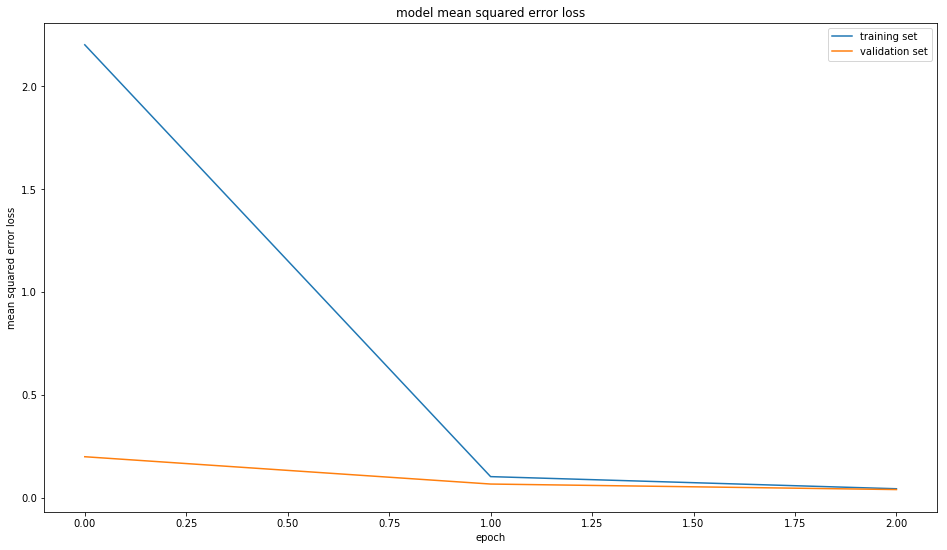

In [22]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [23]:
del model